# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [22]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [23]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (145.5, 147)
LAT_LIMITS = (24.5, 26)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2025-05-12T00:00:00", "2025-05-12T12:00:00"]

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
data_dir = os.path.join('../', '../', '1_preproc_data', 'non_proc_data', 'himawari', 'himawari_tutorial_01')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

##### Retrieve the required complete Himawari data files

For long series we want to download, crop, and process in one go to save disk space.

In [24]:
crop_app = 'test_project2'

ds_all = himawari.load_crop_process_series_nasa(data_dir, time_lims, ll_box, file_app=crop_app, overwrite=True)
ds_all.to_netcdf(os.path.join(data_dir, crop_app + '_compiled.nc'))

# Optional: delete the individual cropped files to save space
_=[os.remove(os.path.join(data_dir, f)) for f in os.listdir(data_dir) if (crop_app in f) & ('L3C' in f)]

ds_all

EarthAccess authenticated: True


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 173.63it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]


Downloaded and verified: 20250511230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1274.48it/s]
PROCESSING TASKS | :   0%|          | 0/1 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [4]:
ds_all = xr.open_dataset(os.path.join(data_dir, crop_app + '_compiled.nc'))
ds_all

<xarray.Dataset> Size: 261kB
Dimensions:    (time: 12, lat: 25, lon: 25)
Coordinates:
  * time       (time) <U19 912B '2025-05-12T00:00:00' ... '2025-05-12T11:00:00'
  * lat        (lat) float64 200B 24.53 24.59 24.65 24.71 ... 25.85 25.91 25.97
  * lon        (lon) float64 200B 145.5 145.6 145.7 145.7 ... 146.8 146.9 147.0
    LON        (lat, lon) float64 5kB ...
    LAT        (lat, lon) float64 5kB ...
    X          (lat, lon) float64 5kB ...
    Y          (lat, lon) float64 5kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 60kB ...
    dTdt       (time, lat, lon) float64 60kB ...
    dTdx       (time, lat, lon) float64 60kB ...
    dTdy       (time, lat, lon) float64 60kB ...

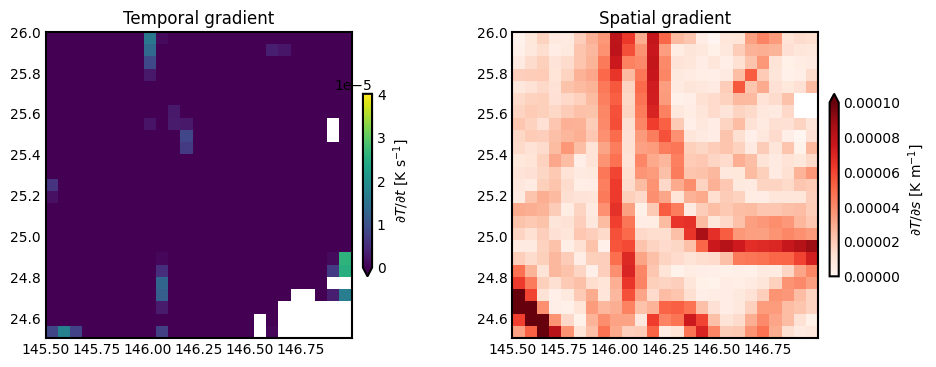

In [6]:
fig, ax = plots.plot_gradients(ds_all.isel(time=10), sg_names=['dTdx','dTdy'])

# Using the de Kreij code to make a GP prediction

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

In [9]:
guess_params = {
    "sigma_u": 9e-2,
    "l_u": 3e4,
    "tau_u": 1e-2,
    "sigma_v": 9e-2,
    "l_v": 3e4,
    "tau_v": 1e-2,
    "sigma_S": 3e-7,
    "l_S": 2e4,
    "tau_S": 2e-7,
    "sigma_tau": 1e-2,
}

print("Calculating GP regression prediction")
ds_all = gpr.predict_series(ds_all, guess_params)

Calculating GP regression prediction


/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/Inpex/pl/pckgs/inversion-sst-gp/pkg/inversion_sst_gp/gp_regression.py:660: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


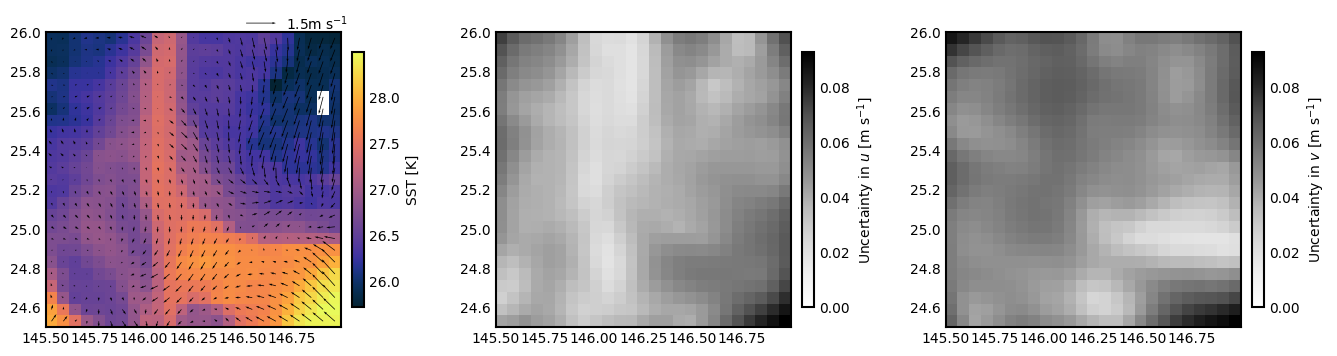

In [10]:
# Plot the mean estimation
fig, ax = plots.plot_prediction(ds_all.isel(time=10), qk_size=1.5)

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [11]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

ds_one = ds_all.isel(time=0)
results = gpr.run_gprm_optim_xr(ds_one, prop_sat)
results

Running GP optimization
sigma_u       l_u           tau_u         sigma_S       l_S           tau_S         sigma_tau     lml        
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01        

{'step': '2025-05-12T00:00:00',
 'est_params': {'sigma_u': np.float64(0.19284197780159618),
  'l_u': np.float64(13048.483392587656),
  'tau_u': np.float64(0.010024114364856791),
  'sigma_S': np.float64(1.2245061434535165e-05),
  'l_S': np.float64(17927.80317546584),
  'tau_S': np.float64(6.163925546338405e-07),
  'sigma_tau': np.float64(0.01142253249847384),
  'l_v': np.float64(13048.483392587656),
  'sigma_v': np.float64(0.19284197780159618),
  'tau_v': np.float64(0.010024114364856791)}}

In [ ]:
# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(14, 'h').astype('timedelta64[ns]')

results_step = gpr.fit_series(ds_all, prop_sat, refit_time)

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<U19') and dtype('<m8[h]')

In [23]:
_=[print(f'sigma_u = {res_t["est_params"]["sigma_u"]:.3f}') for res_t in results_step]

sigma_u = 0.193
sigma_u = 0.188
sigma_u = 0.200
sigma_u = 0.198
sigma_u = 0.178
sigma_u = 0.167
sigma_u = 0.159
sigma_u = 0.159
sigma_u = 0.173
sigma_u = 0.180
sigma_u = 0.170
sigma_u = 0.158
sigma_u = 0.185
sigma_u = 0.182
sigma_u = 0.194
sigma_u = 0.197
sigma_u = 0.160
sigma_u = 0.171
sigma_u = 0.135
sigma_u = 0.174
sigma_u = 0.141
sigma_u = 0.159
sigma_u = 0.175
sigma_u = 0.188


In [21]:
_=[print(f'l_u = {res_t["est_params"]["l_u"]:.0f}') for res_t in results_step]

l_u = 13048
l_u = 11070
l_u = 10648
l_u = 10296
l_u = 9974
l_u = 12615
l_u = 12746
l_u = 14711
l_u = 11056
l_u = 10080
l_u = 8700
l_u = 9388
l_u = 8864
l_u = 9116
l_u = 7830
l_u = 7863
l_u = 8954
l_u = 6255
l_u = 9029
l_u = 7964
l_u = 4806
l_u = 14154
l_u = 10072
l_u = 11921


In [12]:
print("Calculating GP regression prediction")
ds_step = gpr.predict_series(ds_all, results['est_params'])

Calculating GP regression prediction


/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/Inpex/pl/pckgs/inversion-sst-gp/pkg/inversion_sst_gp/gp_regression.py:660: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


In [ ]:
print("Calculating GP regression prediction")
ds_full = gpr.predict_series(ds_all, results_step)

Calculating GP regression prediction


/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/Inpex/pl/pckgs/inversion-sst-gp/pkg/inversion_sst_gp/gp_regression.py:654: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t,p in zip(range(ds.dims['time']), params):


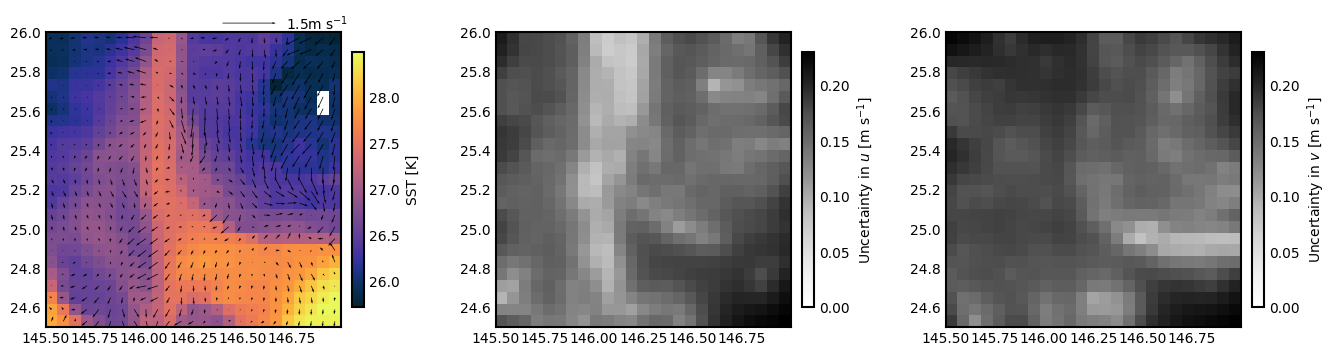

In [14]:
fig, ax = plots.plot_prediction(ds_step.isel(time=10), qk_size=1.5)

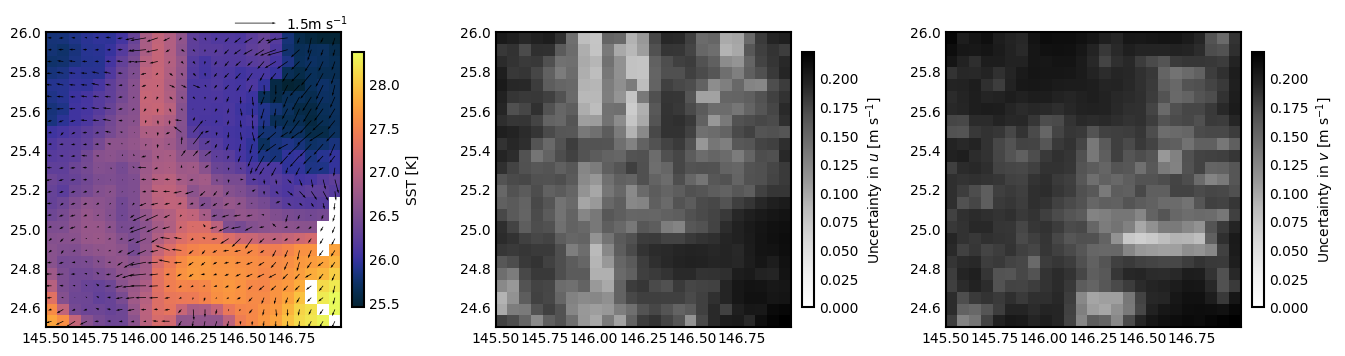

In [15]:
fig, ax = plots.plot_prediction(ds_all.isel(time=14), qk_size=1.5)

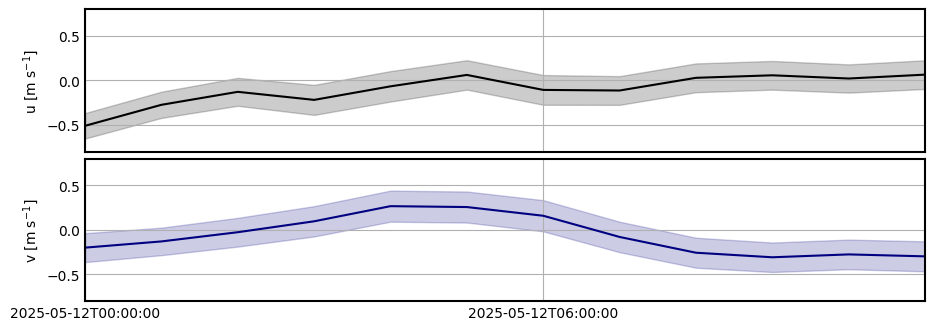

In [15]:
fig, ax = plots.plot_timeseries(ds_step, lon_pt=146.5, lat_pt=25.5, xl_thin=6)

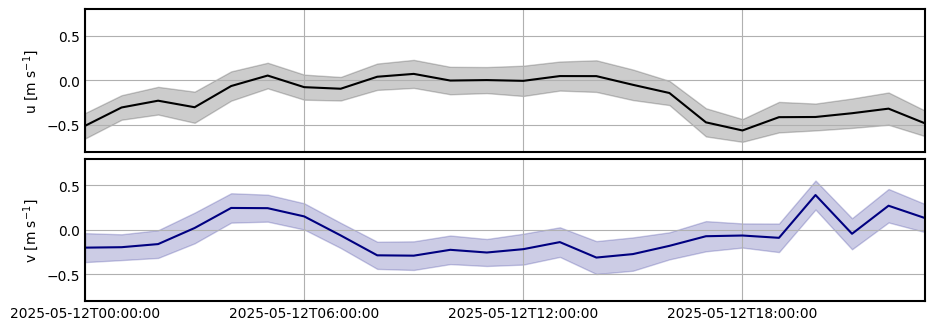

In [18]:
fig, ax = plots.plot_timeseries(ds_all, lon_pt=146.5, lat_pt=25.5, xl_thin=6)

In [17]:
from IPython.display import HTML
%matplotlib notebook

ani = plots.plot_prediction_animation(ds_all, qk_size=1.5)
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>